# Malaria Detection using Deep Learning Techniques

## Table of Contents

- [Implementation](#6)

     - [1 Packages and Libraries](#6.1)
     
     - [2 Exploratory Image Analysis](#6.2)
     
         - [2.1 Read and display samples of Whole Slide Images](#6.2.1)
         
             - [2.1.1 Parasitized Samples](#6.2.1.1)
             
             - [2.2.2 Non-Parasitized Samples](#6.2.2.2)
             
         - [2.2  Data Labelling](#6.2.2)
         
         - [2.3 Image Dimensions](#6.2.3)
         
             - [2.3.1 Parasitized Samples](#6.2.3.1)
             
             - [2.3.2 Non-Parasitized Samples](#6.2.3.2)
             
             - [2.3.3 Summary](#6.2.3.3)
             
         - [2.4 Image Resize](#6.2.4)
         
         - [2.5 Image Color Distribution and Histograms](#6.2.5)
         
             - [2.5.1 Parasitized Samples](#6.2.5.1)
             
             - [2.5.2 Non-Parasitized Samples](#6.2.5.2)
             
         - [2.6 Filtering - Noise Removal](#6.2.6)
         
         - [2.7 Data Augmentation](#6.2.7)
         
             - [2.7.1 Horizontal and Vertical Flip Augmentation](#6.2.7.1)
             
             - [2.7.2 Horizontal and Vertical Shift Augmentation](#6.2.7.2)
             
             - [2.7.3 Random Rotation Augmentation](#6.2.7.3)
             
             - [2.7.4 Random Brightness Augmentation](#6.2.7.4)
             
             - [2.7.5 Random Zoom Augmentation](#6.2.7.5)
             
             - [2.7.6 Random Shear Augmentation](#6.2.7.6)
             
             - [2.7.7 Random Channel Shift Augmentation](#6.2.7.7)
             
         - [2.8 Exploratory Image Analysis - Summary](#6.2.8)
         
     - [3 Model Dataset Creation & Train Test Validation Split](#6.3)
     
         - [3.1 Image Rezise - Train Test Validation ImageSets](#6.3.1)
         
         - [3.2 Label Encoding - Train & Validation](#6.3.2)
         
     - [4 Model Training & Validation](#6.4)
     
         - [4.1 Custom Model 1 (Global Average Pooling)](#6.4.1)
         
         - [4.2 Grad - CAM Visual Explainations](#6.4.2)
         
     - [5 Summary](#6.5)

<a name='6'></a>
# Implementation


<a name='6.1'></a>
## 1 Packages and Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import datetime
import glob
import random as rn
import gc
from collections import Counter

import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.offline as py
%config InlineBackend.figure_format = 'retina'
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default='notebook'

from scipy import stats
from statistics import mean 
from statistics import median 
import seaborn as sns
import cv2

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

import tensorflow as tf

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

# from keras import backend as K
# from keras.backend.tensorflow_backend import set_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import get_session

from IPython.display import Markdown

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Import custom packages and utility files

from DataUtility import dataUtils
dUtils = dataUtils()

from DataUtility import IMAGE_AUGMENTATION_TYPE
from DataUtility import RBC_CELL_TYPE

from ModelTrainer import MalariaNet
MalNetTrainer = MalariaNet()

from MalariaModelBuilder import ModelBuilder
MalNetBuilder = ModelBuilder()

from ModelValidator import ValidateModel
MalNetValidator = ValidateModel()

from CustomImageDataGenerator import CustomDataGenerator
MalNetImageGenerator = CustomDataGenerator()

from GradCamUtility import GradCamUtils
MalNetActivations = GradCamUtils()

from Snapshot_Ensembler import SnapshotEnsemble

<a name='6.2'></a>

# 2 Exploratory Image Analysis

In this section, we will explore the various image pre-processing techniques that can be applied to out dataset and make them ready to be fed to the deep learning systems.

<a name='6.2.1'></a>
### 2.1 Read and display samples of Whole Slide Images

<a name='6.2.1.1'></a>
#### 2.1.1 Parasitized Samples

<br>

***Samples of the Red Blood Cells infected by Malarial Parasites...***

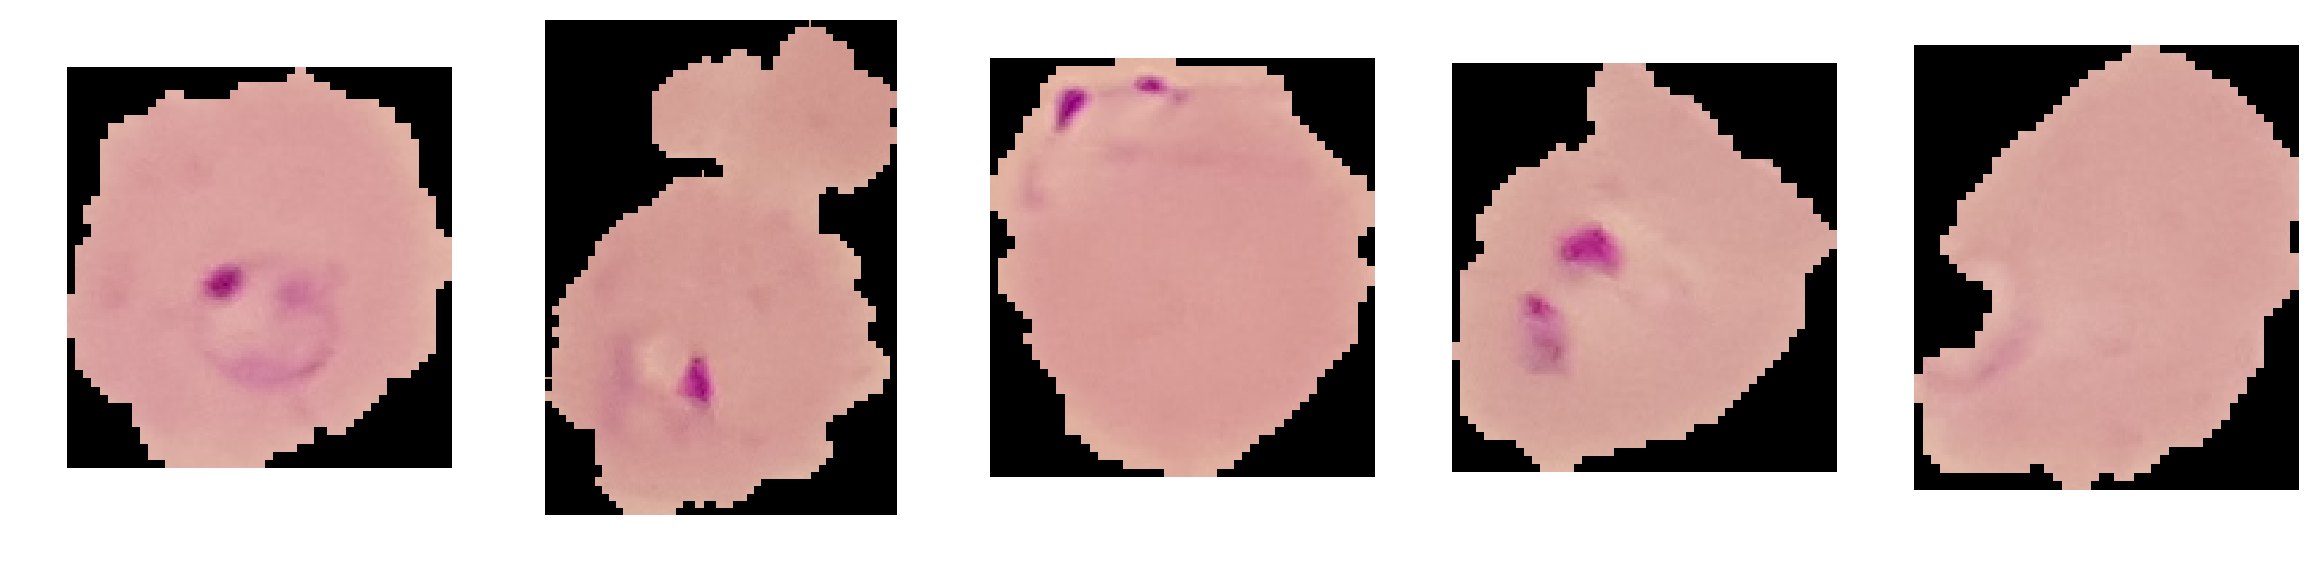

In [3]:
dUtils.PrintMarkdownText('***Samples of the Red Blood Cells infected by Malarial Parasites...***')
dUtils.ReadAndDisplayInputImages(RBC_CELL_TYPE.PARASITIZED.value, 5)

**`As seen in the images above, the parasitized images have a purple colored structure which is the parasite afftected region in the red blood cell. These structures can have a varried shapes and sizes like a ring or oval structure. These ring like structures, their shape, size and the change in color after the staining process helps in determining the parasite species the cell is infected by.`**

<a name='1.2.1.2'></a>
#### 2.1.2 Non-parasitized Samples

<br>

***Samples of the normal Red Blood Cells...***

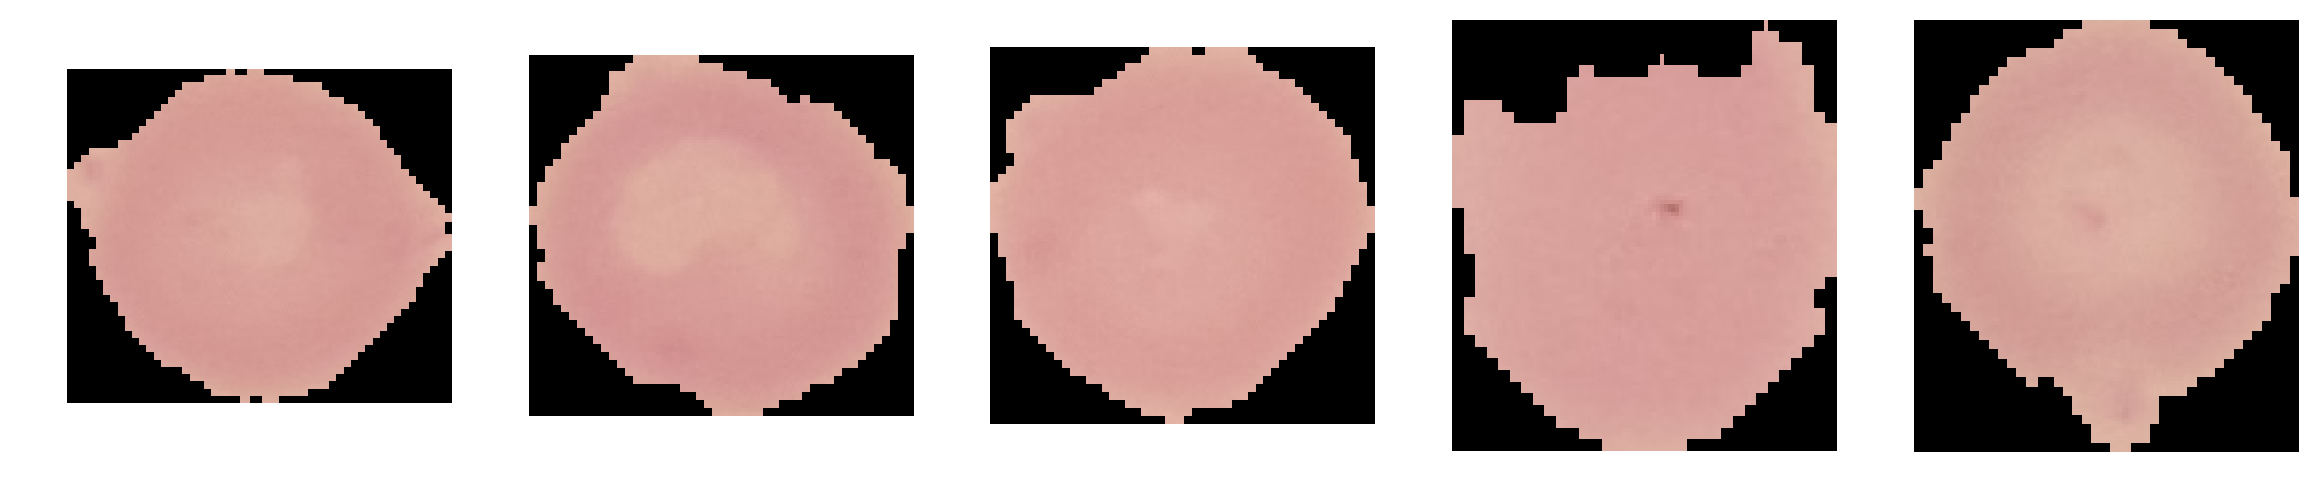

In [4]:
dUtils.PrintMarkdownText('***Samples of the normal Red Blood Cells...***')
dUtils.ReadAndDisplayInputImages(RBC_CELL_TYPE.NONPARASITIZED.value, 5)

<a name='6.2.2'></a>
### 2.2 Data Labelling

The images we have are un-labelled data. Deep learnins systems require proper annotated data to be able to learn the specific representations of each class and perform the job on unseen real time data. So, before proceeding with furtehr analysis we will first assign labels to our data. We have 2 class of images -

1. **Parasitized**

2. **Nonparasitized (or Uninfected)**

Parasitized will be assigned values of 1 and Nonparasitized will be assigned the value 0.

In [3]:
malaria_df = dUtils.GetLabelledMalarialData()

dUtils.PrintMarkdownText('***Labelled malarial images...***')
malaria_df.head()

<br>

***Labelled malarial images...***

,filename,label
0,cell_images/Parasitized\C118P79ThinF_IMG_20151...,Parasitized
1,cell_images/Uninfected\C135P96ThinF_IMG_201510...,NonParasitized
2,cell_images/Uninfected\C94P55ThinF_IMG_2015082...,NonParasitized
3,cell_images/Parasitized\C128P89ThinF_IMG_20151...,Parasitized
4,cell_images/Uninfected\C82P43ThinF_IMG_2015081...,NonParasitized


In [6]:
dUtils.PrintMarkdownText('***Annotated malarial dataframe Info...***')
malaria_df.info()

<br>

***Annotated malarial dataframe Info...***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27558 entries, 0 to 27557
Data columns (total 2 columns):
filename    27558 non-null object
label       27558 non-null object
dtypes: object(2)
memory usage: 430.7+ KB


<br>

***Sample Annotated Parasitized & Non-parasitized Images...***

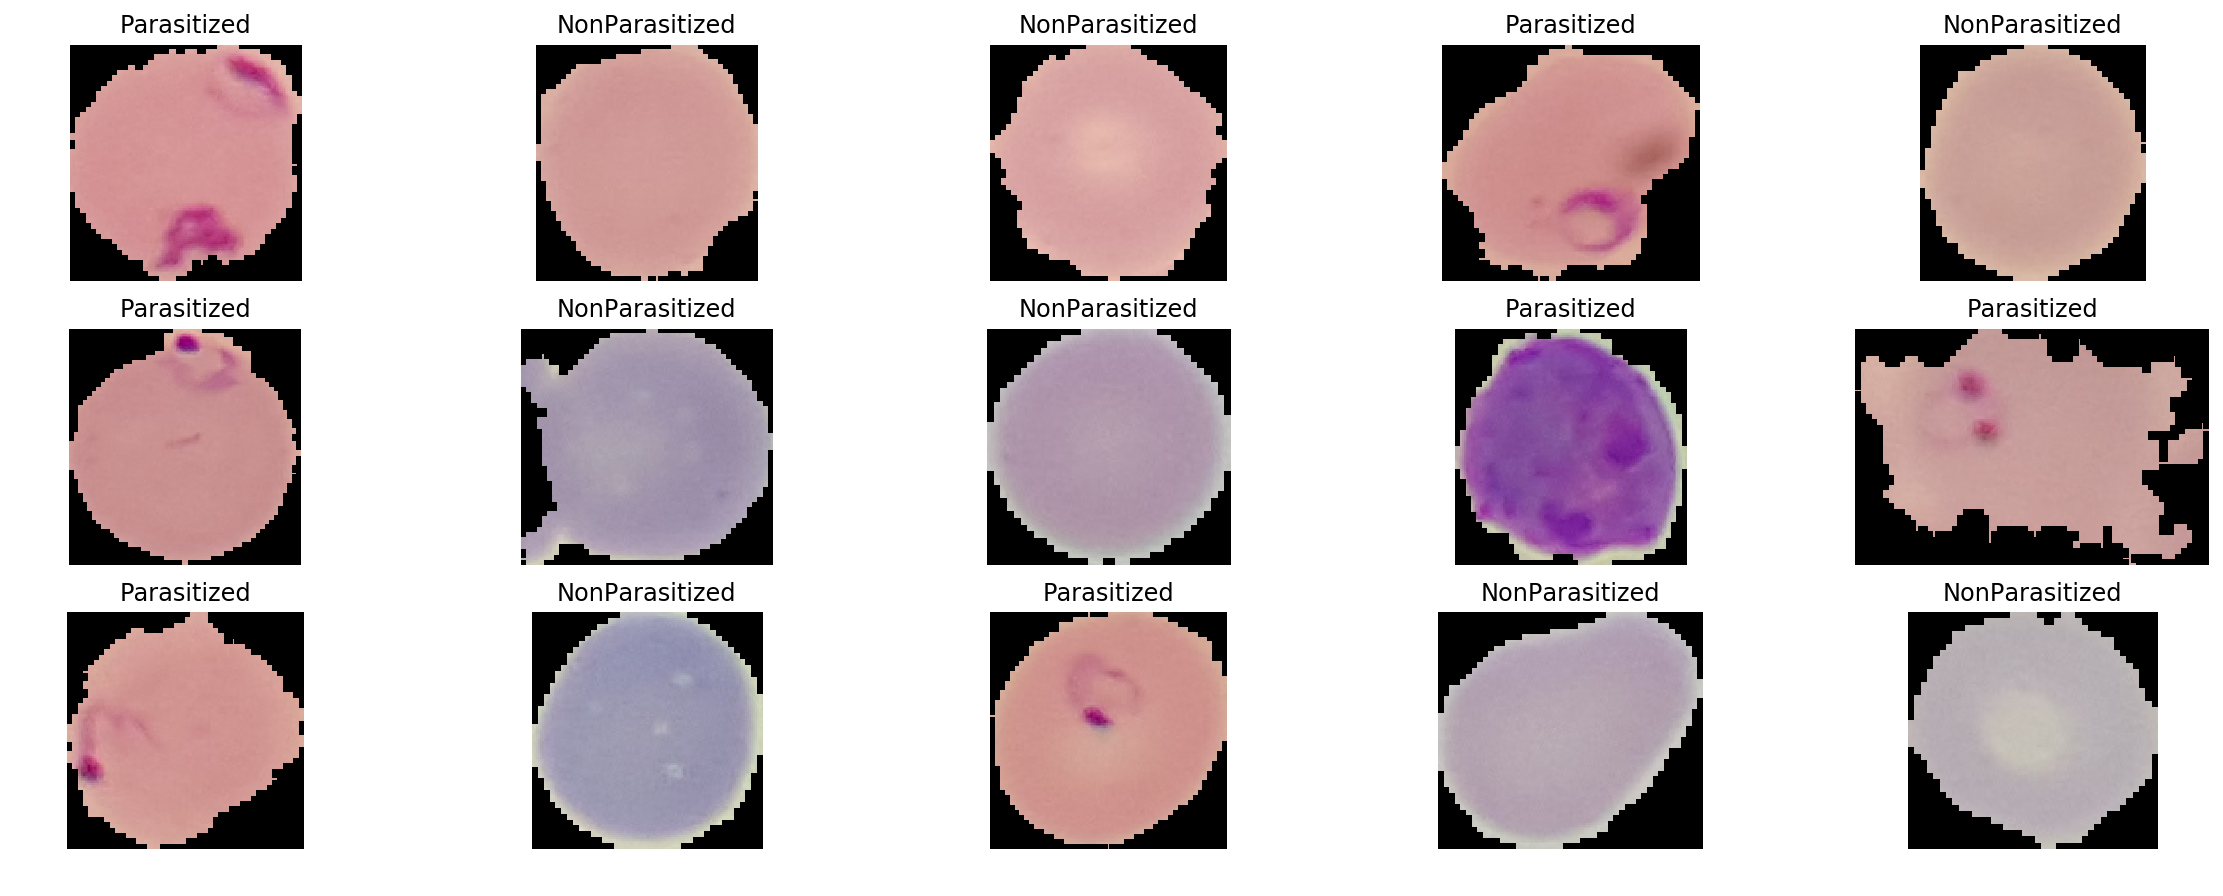

In [7]:
dUtils.PrintMarkdownText('***Sample Annotated Parasitized & Non-parasitized Images...***')
dUtils.DisplayAnnotatedImages(malaria_df, 15)

**Now we have the labels assigned for all the images. As seen the images in both the classes are varrying in dimensions. Lets see the unique sizes of the images we have and the total variations...**
    


<a name='6.2.3'></a>    
### 2.3 Image Dimensions

<a name='6.2.3.1'></a>
#### 2.3.1 Parasitized Samples

In [8]:
# dUtils.PrintMarkdownText('***Shape Distribution for Parasitized Images:***')
# dUtils.ComputeAndPlotImageDimensionalStatistics(RBC_CELL_TYPE.PARASITIZED.value)

<a name='6.2.3.2'></a>
#### 2.3.2 Non-parasitized Samples

In [9]:
# dUtils.PrintMarkdownText('***Shape Distribution for Non-Parasitized Images:***')
# dUtils.ComputeAndPlotImageDimensionalStatistics(RBC_CELL_TYPE.NONPARASITIZED.value)

<a name='6.2.3.3'></a>
***Image Dimensions - SUMMARY :***
    
   So, there are a total of **`1402 unique sized samples`** in the parasitized category & **`1207 unique sized samples`** 
   in the Non-parasitized category. 

   One of the most basic requirement for a smoother model training experience and make the model invariant to varied input
   sizes, resizing is applied such that all the images have a standard size defined for the algorithm. In the context of 
   this study, as seen above the number of uniquely sized images are on the higher side, all the images need to be 
   converted such that they all are of the same dimension. This conversion could be based on the statistical features like 
   the mean or the median size of the images. Lets analyze the statistical distribution of the image size and shape for 
   each category...
   
   Based on the statistical numbers, the size distribution is revolving around the 130 mark for both the parasitized and 
   non-parasitized categories. We will choose **`(135, 135, 3)`** as the common dimension to resize the images.
   
   Below is one example of an image resized to (135, 135, 3).

<a name='6.2.4'></a>

### 2.4 Image Resize - One Sample Image

<br>

***Original vs. Resized Image:***

<Figure size 1440x720 with 0 Axes>

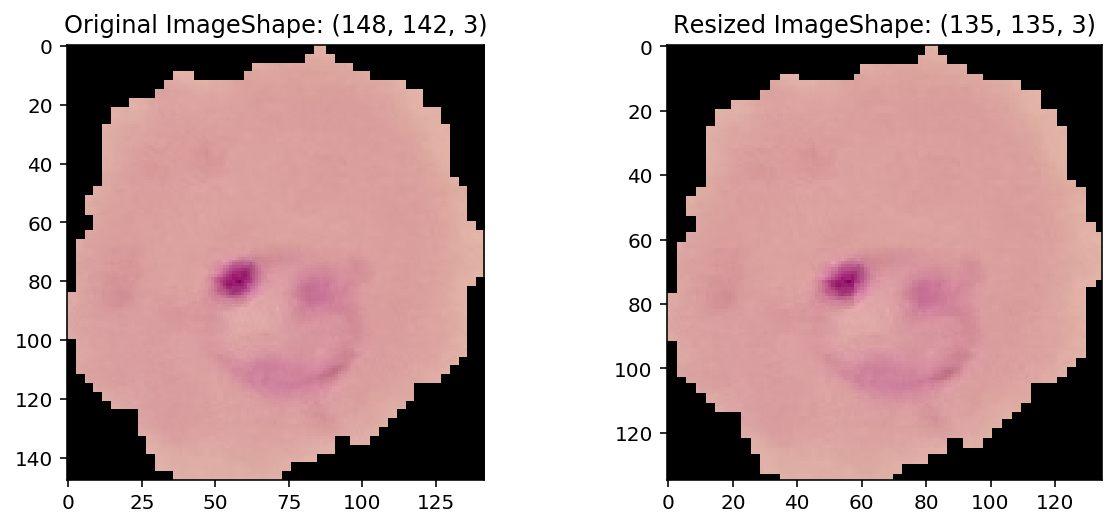

In [10]:
dUtils.PrintMarkdownText('***Original vs. Resized Image:***')

image = dUtils.GetSampleImage(RBC_CELL_TYPE.PARASITIZED.value)
resized_image = cv2.resize(image, (135, 135), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 2)
f.set_figwidth(10)

# Display the Original and the New Resized Image
axes[0].imshow(image)
axes[1].imshow(resized_image)

axes[0].title.set_text('Original Image' + 'Shape: %s' % (image.shape,))
axes[1].title.set_text('Resized Image' + 'Shape: %s' % (resized_image.shape,))

<a name='6.2.5'></a>

### 2.5 Image Color (RGB) Distribution and Histograms

<a name='6.2.5.1'></a>
#### 2.5.1 Parasitized Samples

<br>

***RGB Color Distribution & Histogram in a sample parasitized image***

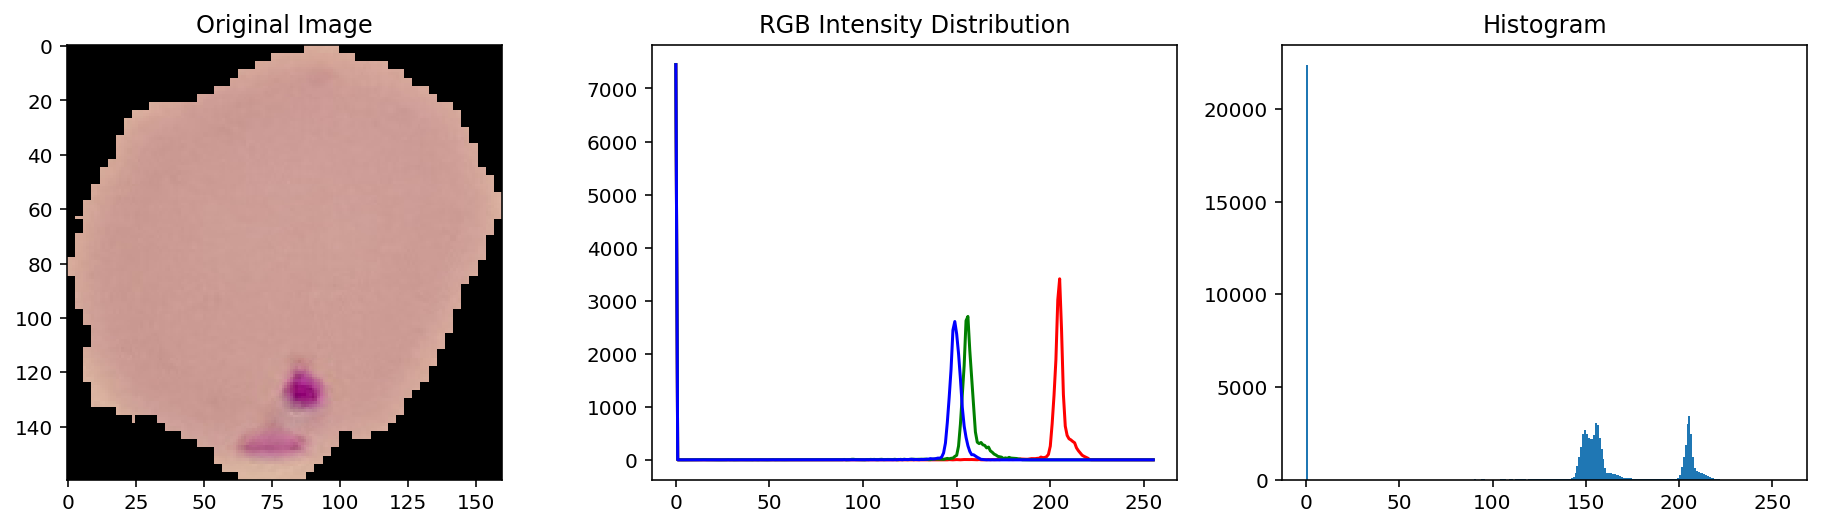

In [11]:
dUtils.PrintMarkdownText("***RGB Color Distribution & Histogram in a sample parasitized image***")
dUtils.PlotImageColorDistribution(RBC_CELL_TYPE.PARASITIZED.value)

<a name='6.2.5.2'></a>
#### 2.5.2 Non-Parasitized Samples

<br>

***RGB Color Distribution & Histogram in a sample non-parasitized image***

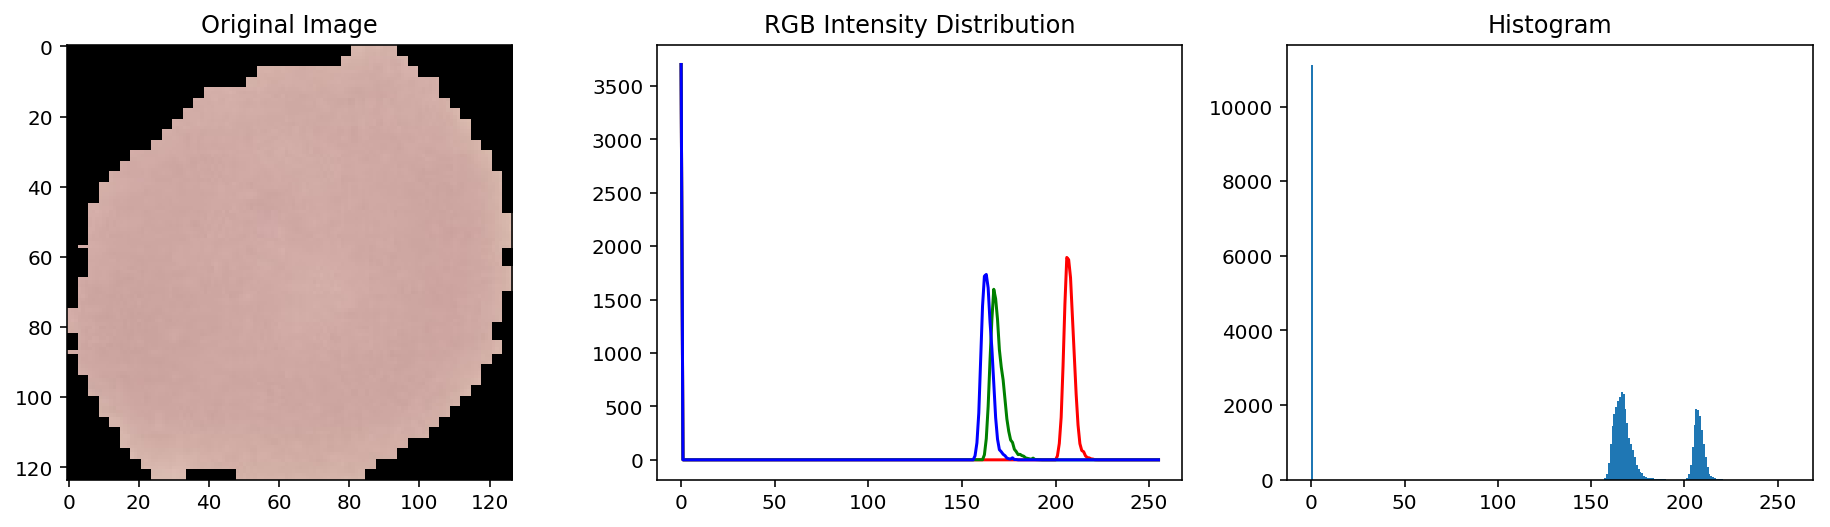

In [12]:
dUtils.PrintMarkdownText("***RGB Color Distribution & Histogram in a sample non-parasitized image***")
dUtils.PlotImageColorDistribution(RBC_CELL_TYPE.NONPARASITIZED.value)

**`As seen for both the parasitized and the non-parasitized cell types, the RGB values are almost on the same intensity levels. Also, the values are around the (140 - 220) range for both the categories.`**

<a name='6.2.6'></a>

### 2.6 Filtering - Noise Removal

***Any random variation that get captured with the image due to uneven lighting conditions, environmental inconsistencies, dust inside the camera can distort and degrade the quality of the image is categorized as noise. Noise is some form is always present in the image (Hambal et al., 2017). The presence of noise in the image could impact a model’s performance. Thus, noise of any kind needs to be removed from the images for an accurate classification.***

We will see the various filetring techniques that are applied for noise removal.

([], <a list of 0 Text yticklabel objects>)

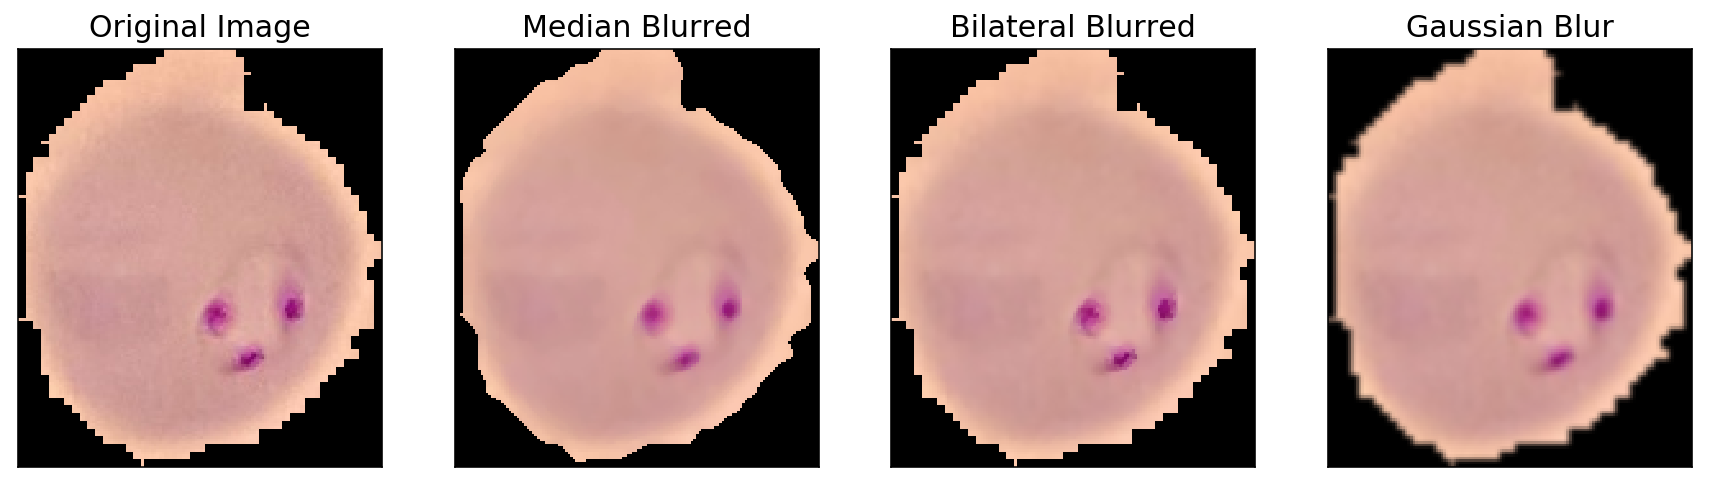

In [13]:
# parasitized = dUtils.GetSampleImage(RBC_CELL_TYPE.PARASITIZED.value)

parasitized = cv2.imread('cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png')
parasitized = cv2.cvtColor(parasitized, cv2.COLOR_BGR2RGB)

# Apply various filters...
median_blurr = cv2.medianBlur(parasitized, 5)
bilateral_blurr = cv2.bilateralFilter(parasitized, 5, 25, 25)
gauss_blurr = cv2.GaussianBlur(parasitized,(5,5),0)

plt.figure(figsize=(15, 20))

plt.subplot(141)
plt.imshow(parasitized)
plt.title('Original Image', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.imshow(median_blurr)
plt.title('Median Blurred', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.imshow(bilateral_blurr)
plt.title('Bilateral Blurred', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.imshow(gauss_blurr)
plt.title('Gaussian Blur', size=15)
plt.xticks([])
plt.yticks([])

**`==> From the above plots, we see that Bilateral filter works well and it preserves the edges too. However, literature survey reveals that the median filtering is the most widely applied technique. So, it remains to be seen which technique will be the better approach for this study.`**

<a name='6.2.7'></a>

### 2.7 Data Augmentation

The term Augmentation refers to making something larger in size. In the context of data, we try to increase the size of the dataset by creating more transformed copies of the original data. This process **`increases the diversity`** in the dataset. Such transformed images help to make the model more robust in handling the real-time images and increase the generalizability of the system. In the context of bio-medical image data, the samples differ from case to case basis. A similar health condition can form a completely different Whole Slide Image. Thus, a deep learning model should be robust enough and be able to generalize on any pattern of the slide image being fed.

In this study, we use the Keras - **`ImageDataGenerator`** module to help with the process of augmentation. The ImageDataGenerator supports various techniques for data augmentation like **`flipping, rotation, cropping, translation, illumination, scaling, adding noise, shift, zooming`**, etc... This enables the model to learn all the variations in these data, increasing the accuracy, robustness and also help to reduce overfitting which often becomes the case with lesser data.

We will see the various augmentation strategies on a sample parasitized red blood cell.

<a name='6.2.7.1'></a>
#### 2.7.1  Horizontal and Vertical Flipping Augmentation

**HORIZONTAL FLIP**

<br>

***Original vs. Augmented Images...***

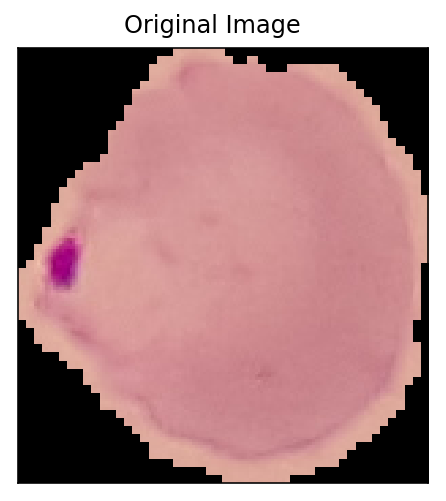

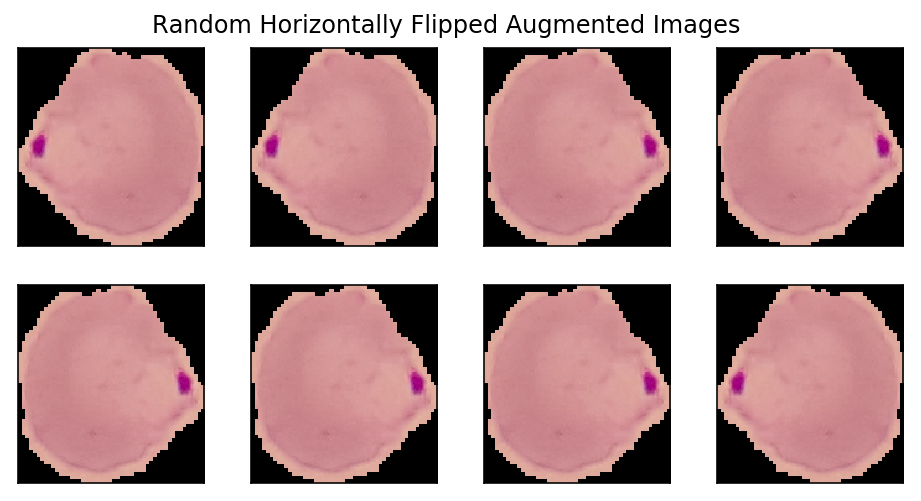

In [14]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.HORIZONTAL_FLIP.value)

**VERTICAL FLIP**

<br>

***Original vs. Augmented Images...***

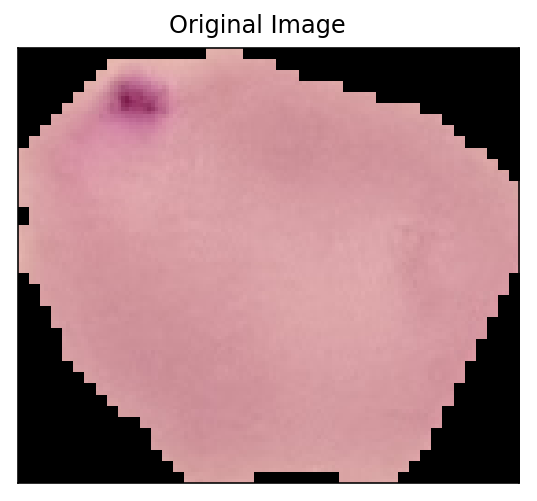

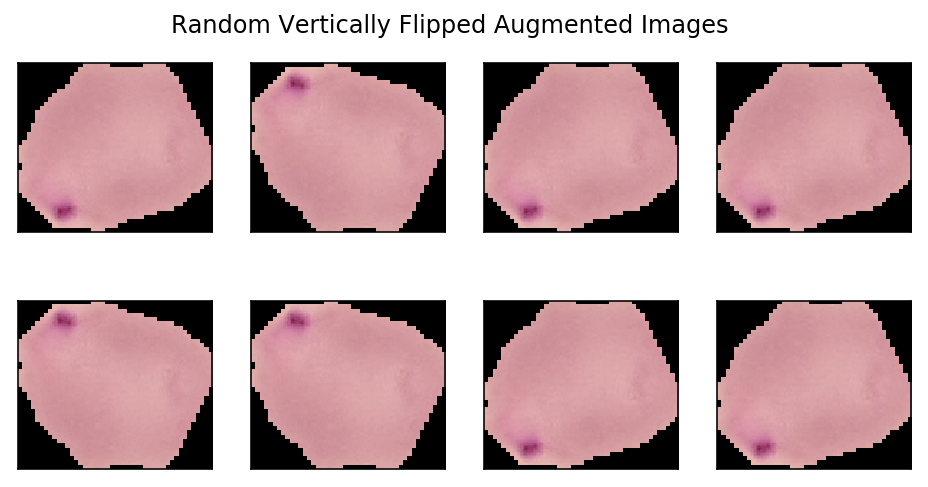

In [15]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.VERTICAL_FLIP.value)

<a name='6.2.7.2'></a>
#### 2.7.2  Horizontal and Vertical Shift Augmentation

**HORIZONTAL SHIFT**

<br>

***Original vs. Augmented Images...***

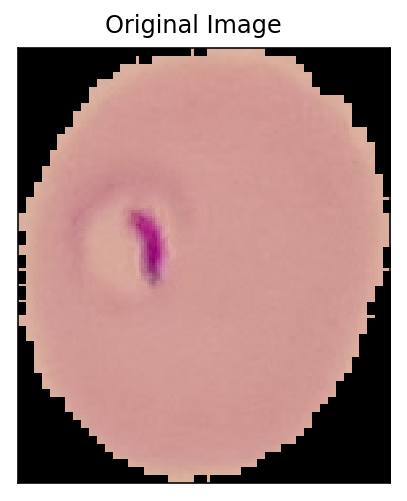

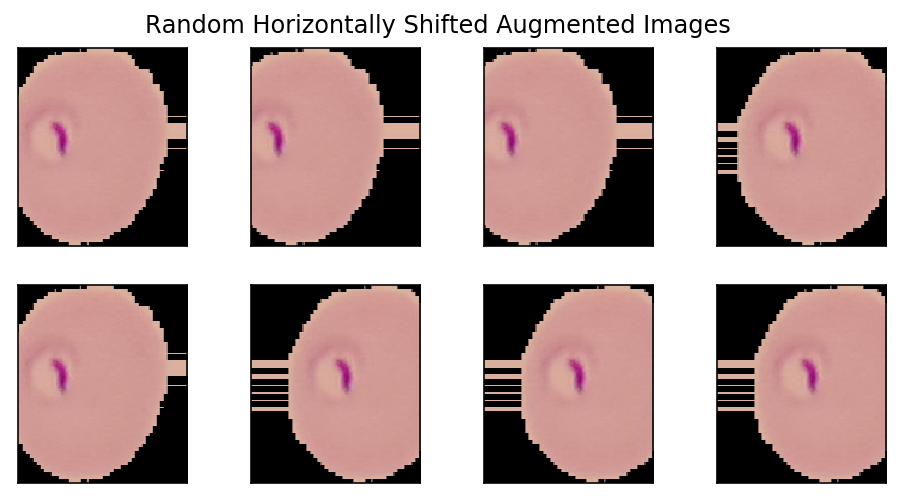

In [16]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.HORIZONTAL_SHIFT.value)

 **VERTICAL SHIFT**

<br>

***Original vs. Augmented Images...***

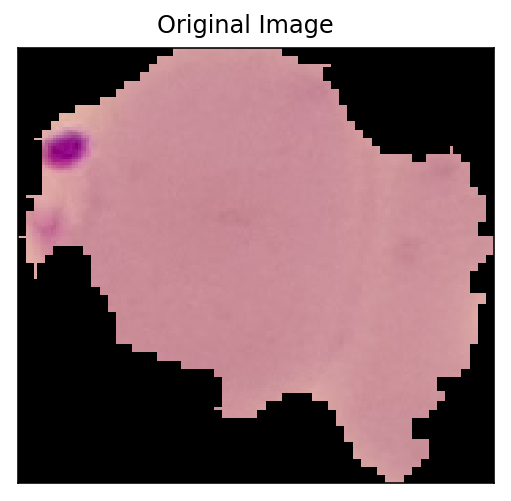

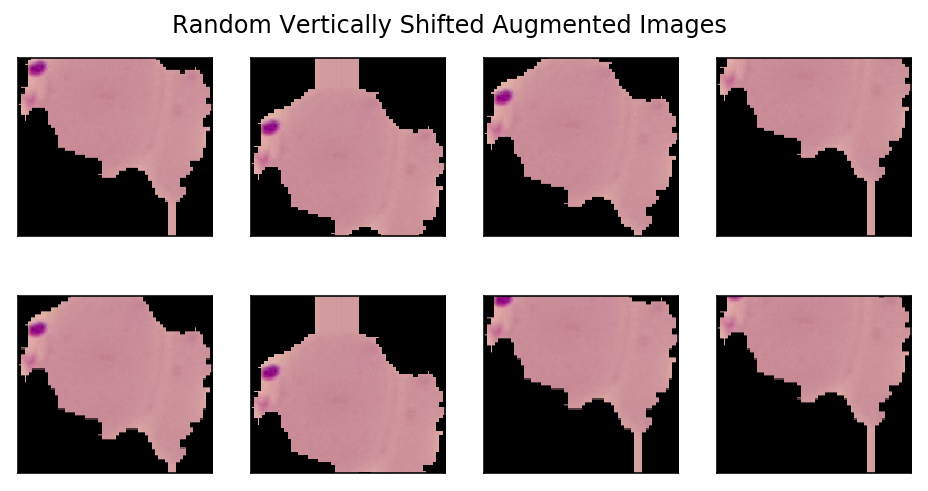

In [17]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.VERTICAL_SHIFT.value)

<a name='6.2.7.3'></a>
#### 2.7.3 Random Rotation Augmentation

<br>

***Original vs. Augmented Images...***

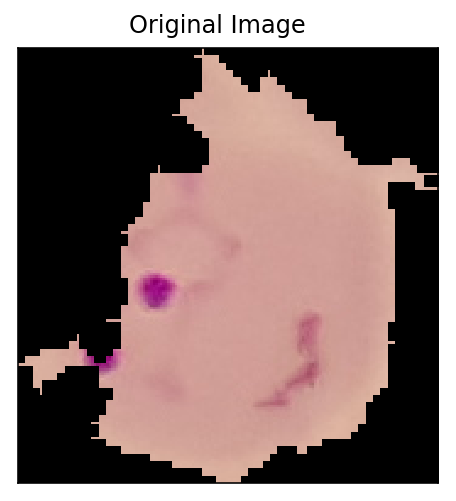

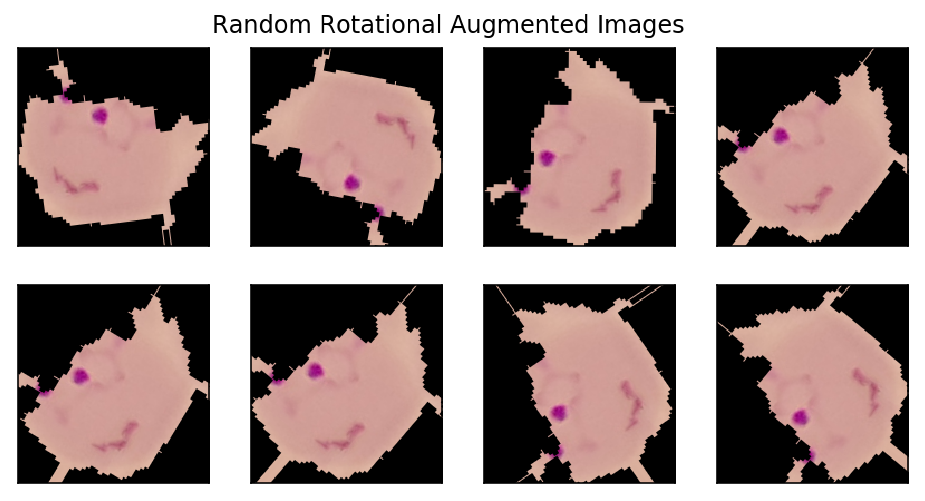

In [18]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_ROTATION.value)

<a name='6.2.7.4'></a>
#### 2.7.4 Random Brightness Augmentation

<br>

***Original vs. Augmented Images...***

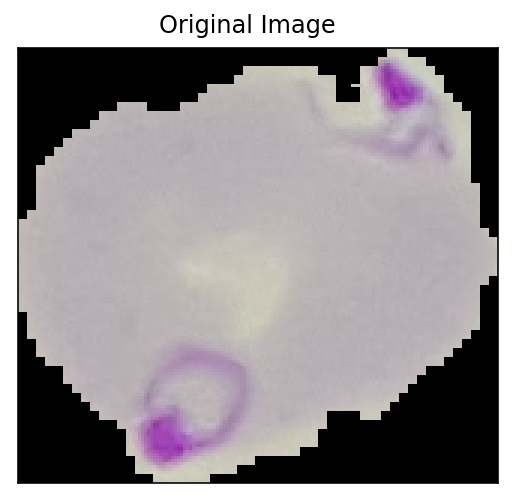

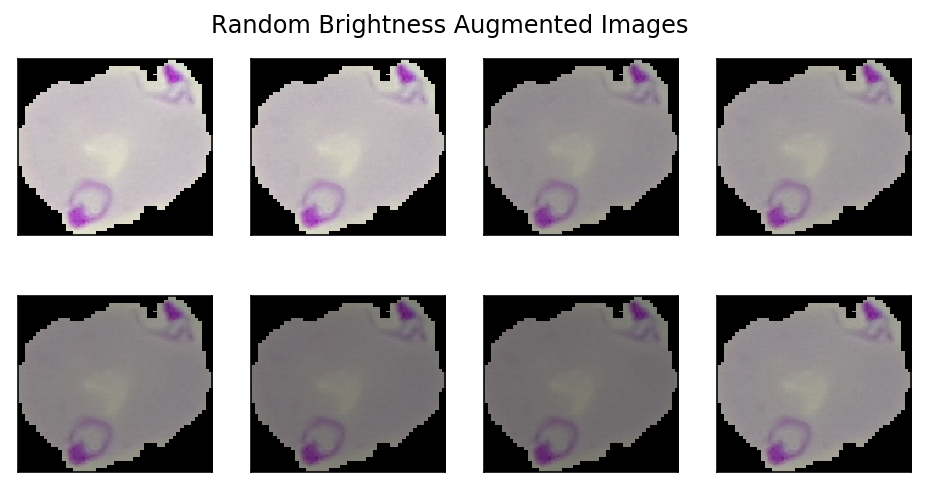

In [19]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_BRIGHTNESS.value)

<a name='6.2.7.5'></a>
#### 2.7.5 Random Zoom Augmentation

<br>

***Original vs. Augmented Images...***

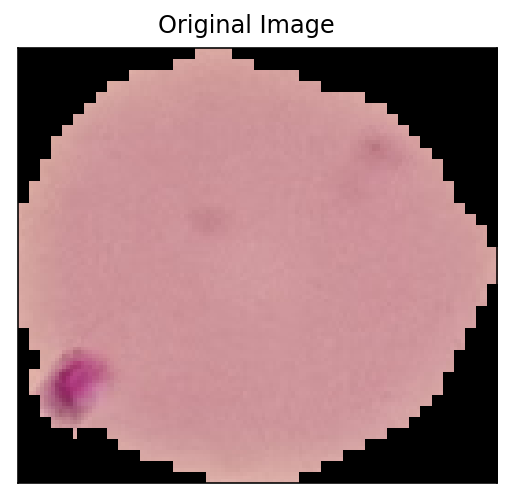

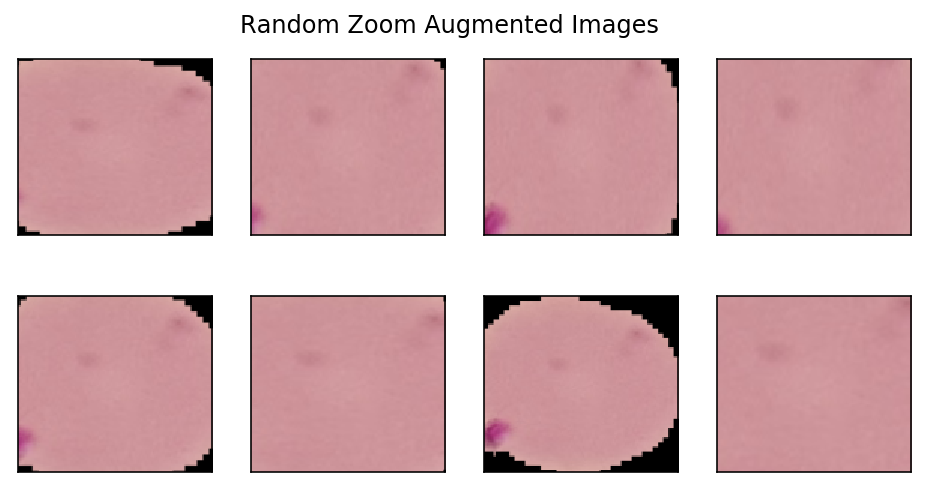

In [20]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_ZOOM.value)

<a name='6.2.7.6'></a>
#### 2.7.6 Random Shear Augmentation

<br>

***Original vs. Augmented Images...***

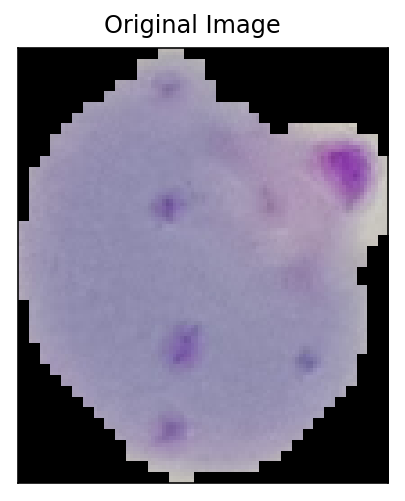

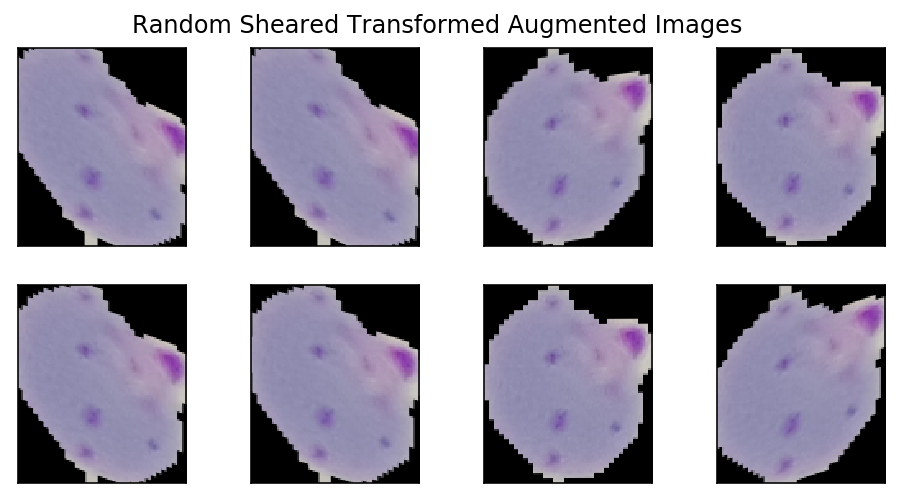

In [21]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_SHEAR.value)

<a name='6.2.7.7'></a>
#### 2.7.7 Random Channel Shift Augmentation

<br>

***Original vs. Augmented Images...***

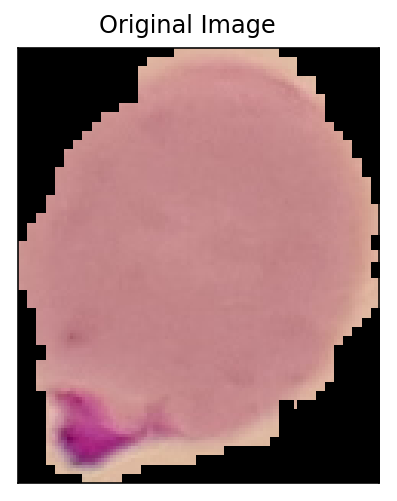

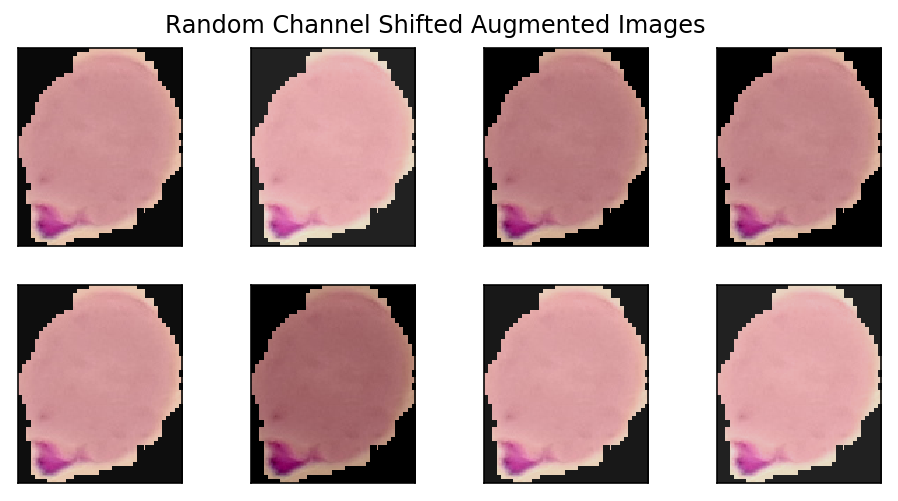

In [22]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.CHANNEL_SHIFT.value)

<a name='6.2.8'></a>
### 2.8 Exploratory Image Analysis - Summary

**With the above exploratory image level analysis, we saw some pre-processing techniques on images that will be the 
pre-requisites for any deep learning system based on images. A summary of the exploratory analysis done so far is 
mentioned below -**

1. **Labelling of Images:** Deep learning systems require annotated data for training. The complete set of images were labelled and divided into 2 classes - **`Parasitized (1)`** & **`Non-parasitized (0)`**.


2. **Image Dimension:** For any algorithm to run and train smoothly the inputs should all be of equal dimensions. Based on the statistical numbers, the size distribution was found to be around the 130 mark for both the parasitized and non-parasitized categories. Thus, **`(135, 135, 3)`** is choosen as the common dimension to resize the images.


3. **Histogram & Color Intensity:** Histograms and RGB color intensity were calculated and plotted on sample images from bith the classes. As seen for both the parasitized and the non-parasitized cell types, the RGB values are almost on the same intensity levels. Also, the values are around the (140 - 220) range for both the categories.


4. **Filtering & Noise Removal:** Median, gaussian and bi-lateral filtering techniques were appplied on sample images. From the corresponding filtered images it can be seen that Bilateral filter works well and it preserves the edges too. However, literature survey reveals that the median filtering is the most widely applied technique. So, it remains to be seen which technique will be the better approach for this study.


5. **Data Augmentation:** Deep learning systems require huge amount of annotated data to be available for training which enables the algorithms learn all the details and variations in the images. Due to a limited dataset available to us, some of the augmentation techniques such as flipping, shifting, rotation, zoom, shear transformation, channel shift, brightness were explored to generate more similar images. The labels of the augmentaed images will be the same as that of the original image.


In adddition to the above pre-processing techniques, all the images will undergo **Normalization** to brings the pixel intensity values to the range of 0-1 and **Standardization** such that the data points such that they follow a ***gaussian distribution*** with mean of zero and standard deviation of one.

<a name='6.3'></a>
# 3 Model Dataset Creation & Train Test Validation Split 

Any Machine Learning/Deep Learning model once trained, needs to be tested on unseen data to check the performance. 

- The data on which the **`model trains`** on is known as the **`Train Dataset`**. 


- The **`unseen data`** on which the trained model is put to **`test for performance`** and get an **`unbiased evaluation`** of the final model is known as the **`Test Dataset`**. 


- There is also an additional dataset created known as the **`Validation Dataset`** which validates the **`performance of the model fit`** during the **`tuning phase of the model hyper-parameters`**.



The percentage of data we would use to split the respective sets would be **`75:15:10`**. As deep learning systems need huge amount of training data, a major chunk - 75% is allocated to the training set. The validation set gets 10% share of the data and while the test set get 15% share.

The full malaria data set (**malaria_df**) is defined in [6.2.2 Data Labelling](#6.2.2) section. We will use the same dataset to construct our train, test and validation subsets of the data.

In [4]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(malaria_df['filename'].values,
                                                                      malaria_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.10, random_state=42)

In [5]:
dUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Validation Set Length: "  + str(len(validation_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 21081 samples
 -- Validation Set Length: 2343 samples
 -- Test Set Length: 4134 samples


In [25]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

dUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nValidation Data:', Counter(validation_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'NonParasitized': 10548, 'Parasitized': 10533}) 

Validation Data: Counter({'Parasitized': 1173, 'NonParasitized': 1170}) 

Test Data: Counter({'Parasitized': 2073, 'NonParasitized': 2061})


<a name='6.3.1'></a>
### 3.1 Image Rezise - Train Test Validation ImageSets

As discussed in [Section 6.2.3](#6.2.3) for Image Dimensions, statistical summary, the images will be resized to 
**`(135, 135)`**. However, for certain pre-trained models for transfer learning the images will be re-sized to the preffered size depending on the models.

In [5]:
IMG_RESIZE_DIMENSIONS = (135, 135)

In [6]:
train_data = dUtils.ResizeAllImages(train_files, IMG_RESIZE_DIMENSIONS)
validation_data = dUtils.ResizeAllImages(validation_files, IMG_RESIZE_DIMENSIONS)
test_data = dUtils.ResizeAllImages(test_files, IMG_RESIZE_DIMENSIONS)

In [7]:
dUtils.PrintMarkdownText('***Train, Test & Validation Image Dimensional Summary...***')
print('Training Data:', train_data.shape, 
      '\n\nValidation Data:', validation_data.shape, 
      '\n\nTest Data:',test_data.shape)

<br>

***Train, Test & Validation Image Dimensional Summary...***

Training Data: (21081, 100, 100, 3) 

Validation Data: (2343, 100, 100, 3) 

Test Data: (4134, 100, 100, 3)


<a name='6.3.2'></a>
### 3.2 Label Encoding

Encode categorical values **(`'Parasitized' & 'NonParasitized'`)** to convert to the machine readable and interpretable values which would be 0 and 1.

In [7]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_validation = lbl_encoder.transform(validation_labels)
y_test = lbl_encoder.transform(test_labels)

dUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Parasitized', 'NonParasitized', 'Parasitized', 'Parasitized', 'NonParasitized'] 

Encoded Train Labels:     [1 0 1 1 0]


*From the above result -*
__________________________

- 1 denotes **`'Parasitized'`** 
- 0 corresponds to **`'NonParasitized'`**

In [8]:
X_train = train_data / 255.
X_val = validation_data / 255.
X_test = test_data / 255.

<a name='6.4'></a>
## 4 Model Training & Validation

In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 50
INPUT_SHAPE = (135, 135, 3)

<a name='6.4.1'></a>
### 4.1 Experiment 1 -  Custom Model with GlobalAveragePooling layer

In [13]:
GAP_Model = MalNetBuilder.BuildCustomModelWith_GAP_Layer()

Model: "Custom_Model_with_GAP_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 135, 135, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 135, 135, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 135, 135, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 67, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 67, 67, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 67,

In [14]:
CallBackList = MalNetTrainer.GetCallBackList("Custom_Model_with_GAP_Layer")
MalNetTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./Custom_Model_with_GAP_Layer.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f349044a4e0>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f349044a400>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x7f349044a518>


In [15]:
# Get the training and validation samples
train_samples = MalNetImageGenerator.Build_Image_Samples(train_files, train_labels)
validation_samples = MalNetImageGenerator.Build_Image_Samples(validation_files, validation_labels)

# Get the training and validation data generators
train_data_generator = MalNetImageGenerator.CustomImageDataGenerator(train_samples)
validation_data_generator = MalNetImageGenerator.CustomImageDataGenerator(validation_samples)

In [16]:
GAP_Model_Train_History = MalNetTrainer.fit_generator(GAP_Model,
                                                      train_data_generator, 
                                                      EPOCHS, 
                                                      validation_data_generator, 
                                                      CallBackList,
                                                      total_train_samples = len(train_samples), 
                                                      total_validation_samples = len(validation_samples))

<br>

***Model Training Started...***

Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8625
Epoch 00001: val_loss improved from inf to 1.61856, saving model to ./Custom_Model_with_GAP_Layer.h5
329/329 [==============================] - 34s 103ms/step - loss: 0.3537 - accuracy: 0.8625 - val_loss: 1.6186 - val_accuracy: 0.4987 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9348
Epoch 00002: val_loss improved from 1.61856 to 0.26343, saving model to ./Custom_Model_with_GAP_Layer.h5
329/329 [==============================] - 33s 100ms/step - loss: 0.1897 - accuracy: 0.9348 - val_loss: 0.2634 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1915 - accuracy: 0.9351
Epoch 00003: val_loss did not improve from 0.26343
329/329 [==============================] - 33s 101ms/step - loss: 0.1915 - accuracy: 0.9351 - val_loss: 0.2649 - val_accuracy: 0.9076 - lr: 0.0010
Epoch 4/50
329

<br>

***Monitoring Model Train History...***

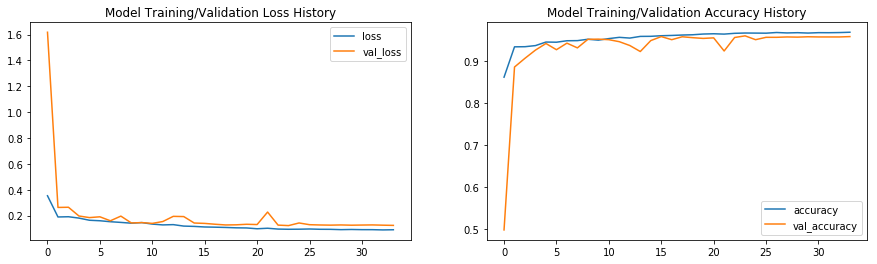

In [17]:
MalNetTrainer.plot_model_history(GAP_Model_Train_History)

In [18]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(GAP_Model, X_test)

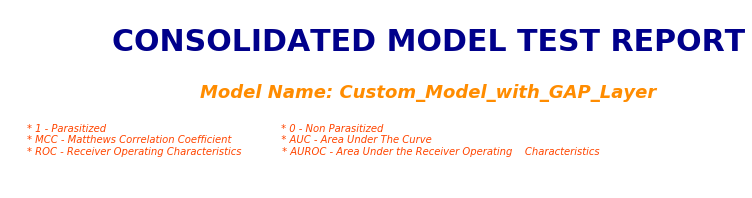

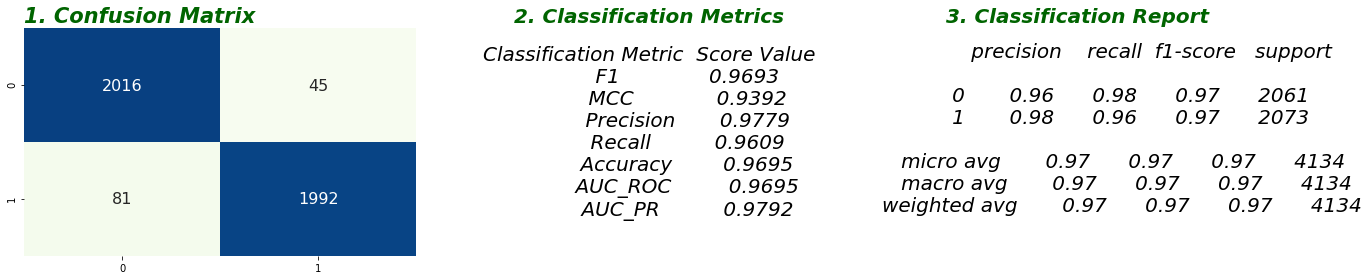

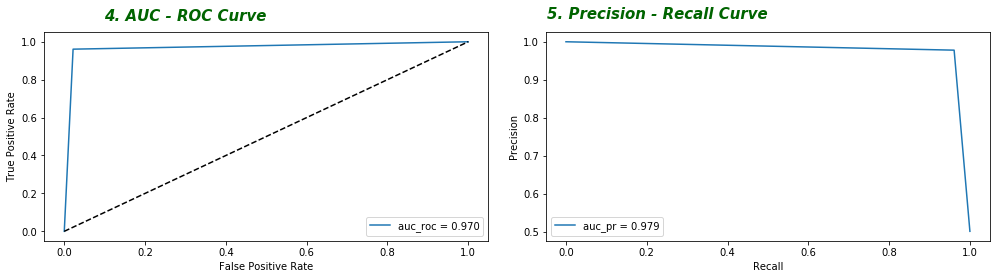

In [19]:
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "Custom_Model_with_GAP_Layer")

<a name='6.4.2'></a>
### 4.2 Experiment 2 - Grad-CAM Class Activation Visualization

Inspired by https://arxiv.org/abs/1610.02391 - ***`"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"`***, the concept was utilized to get the visual representation of our malaria classification model. The GradCAM techniqque utilizes the gradients flowing into the final convolutional layer and computes a rough localization map highlighting important regions in the image that the models tries to see to arrive at the classification decision.

The explaination given by the models should be locally accurate with the models seeing the right objects in the given input image. Lets verify this in the experiment below. The model used is the same as **experiment 1**.

In [19]:
# Get the last layer of the convolutional block
last_conv_layer_name = "batch_normalization_2"

# Get the final classification layers
classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
]

In [31]:
# Prepare the image for prediction and computation of activation maps. 
# As the models needs batch of images, the images are converted to a 4d tensor of shape (1, 135, 135, 3).
img1 = MalNetValidator.PrepareImageForPrediction(X_test[22])
img2 = MalNetValidator.PrepareImageForPrediction(X_test[24])
img3 = MalNetValidator.PrepareImageForPrediction(X_test[25])

In [32]:
# Get the Grad-CAM heatmap for each imagefrom the grdient output of the last convolutional layer.
heatmap1 = MalNetActivations.ComputeGradCAMHeatmap(img1, GAP_Model, last_conv_layer_name, classifier_layer_names)
heatmap2 = MalNetActivations.ComputeGradCAMHeatmap(img2, GAP_Model, last_conv_layer_name, classifier_layer_names)
heatmap3 = MalNetActivations.ComputeGradCAMHeatmap(img3, GAP_Model, last_conv_layer_name, classifier_layer_names)

W0710 14:19:54.591092 140690470274880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 14:19:54.627256 140690470274880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0710 14:19:54.668431 140690470274880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


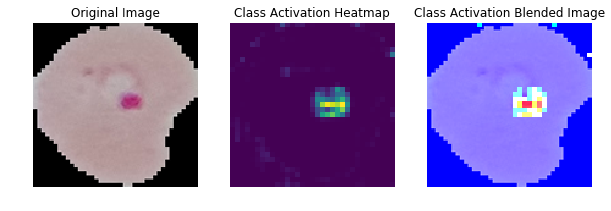

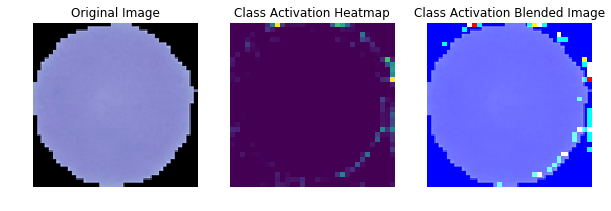

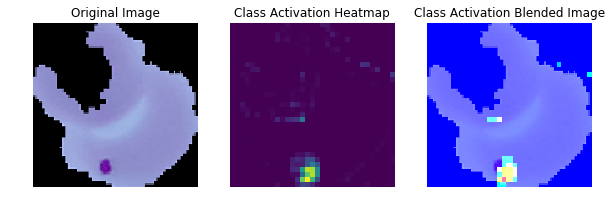

In [39]:
# Get the superimposed images...
super_imposed_image1 = MalNetActivations.GetSuperImposedCAMImage(heatmap1, X_test[22])
super_imposed_image2 = MalNetActivations.GetSuperImposedCAMImage(heatmap2, X_test[24])
super_imposed_image3 = MalNetActivations.GetSuperImposedCAMImage(heatmap3, X_test[25])

# Display the heatmap and the super-imposed images
MalNetActivations.DisplaySuperImposedImages(X_test[22], heatmap1, super_imposed_image1)
MalNetActivations.DisplaySuperImposedImages(X_test[24], heatmap2, super_imposed_image2)
MalNetActivations.DisplaySuperImposedImages(X_test[25], heatmap3, super_imposed_image3)

<a name='6.5'></a>
## 5 Summary

- The custom model achieved a F1 score of 96.93 which is reasonably good. However, the number of false negatives - 81 is on the higher side considering the healthcare domain. The target is to reduce the number of faalse predictions. A person wh has malaria should not be reported as Uninfected. This would hamper the recovery process and could proce fatal as well.

- GRADCAM Viz - The regions in the image which change the final classification probability, assign a higher intensity score to the activation maps.
- The model correctly sees the stained region in the red blood cells.
- Such visuals give a better exlpainability tot he physicians about the thought process of a machine to arrive at a decision. Such abilities would make the adoption of AI systems in the healthcare domain smoother and easier.